In [1]:
import sys
sys.path.append('..') 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import os
import h5py
from utils.basics.data_org import parse_session_string
import json
from matplotlib.gridspec import GridSpec

In [166]:
# load signal from hdf5 file from certain session and channel
# load one nsc file to get recording time:
session = 'mZS059d20210327'
data_dir = parse_session_string(session)

file_loc_csc = os.path.join(r'E:\ZS059\mZS059d20210327\neuralynx\opto\20ms', 'csc_data.hdf5')
file_loc_raw = os.path.join(r'D:\raw_ephys_conversion\ZS059\mZS059d20210327\neuralynx\opto\20ms', 'raw_data.hdf5')
channel_num = 32
num_bins = 5
chunk_size = 5 # seconds
broken_channel = [8]
with h5py.File(file_loc_raw, 'r') as f:
    start = f['/timestamps'][0]
    end = f['/timestamps'][-1]
    ADBitVolts = f.attrs['ADBitVolts']
rec_length = end - start

In [163]:
def print_all_attributes(file_path):
    def visit_func(name, obj):
        for attr_name in obj.attrs:
            print(f"Attribute at '{name}': {attr_name}")

    with h5py.File(file_path, 'r') as f:
        # File-level attributes
        for attr_name in f.attrs:
            print(f"{attr_name}")
        # Dataset/group attributes
        f.visititems(visit_func)

# Example usage
print_all_attributes(file_loc_raw)


ADBitVolts
ADMaxValue
AcquisitionSystem
ApplicationName
FileType
FileUUID
FileVersion
NumADChannels
OriginalFileName
RecordSize
SamplingFrequency
SessionUUID
TimeClosed
TimeCreated


In [167]:
with h5py.File(file_loc_raw, 'r') as f:
    timestamps = f['/timestamps'][:]
    data = f['/samples'][:5, :]


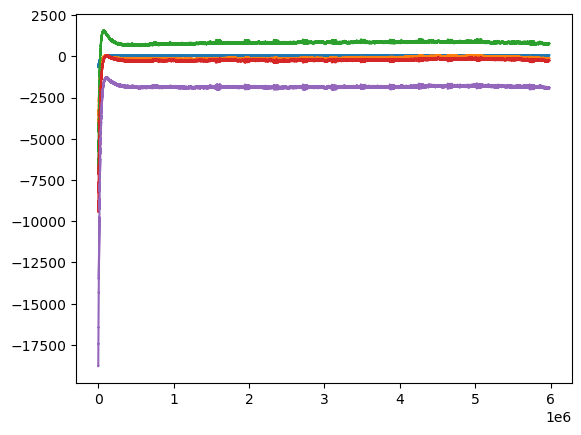

In [171]:
plt.plot(ADBitVolts*data.T* 1e6, label='raw')

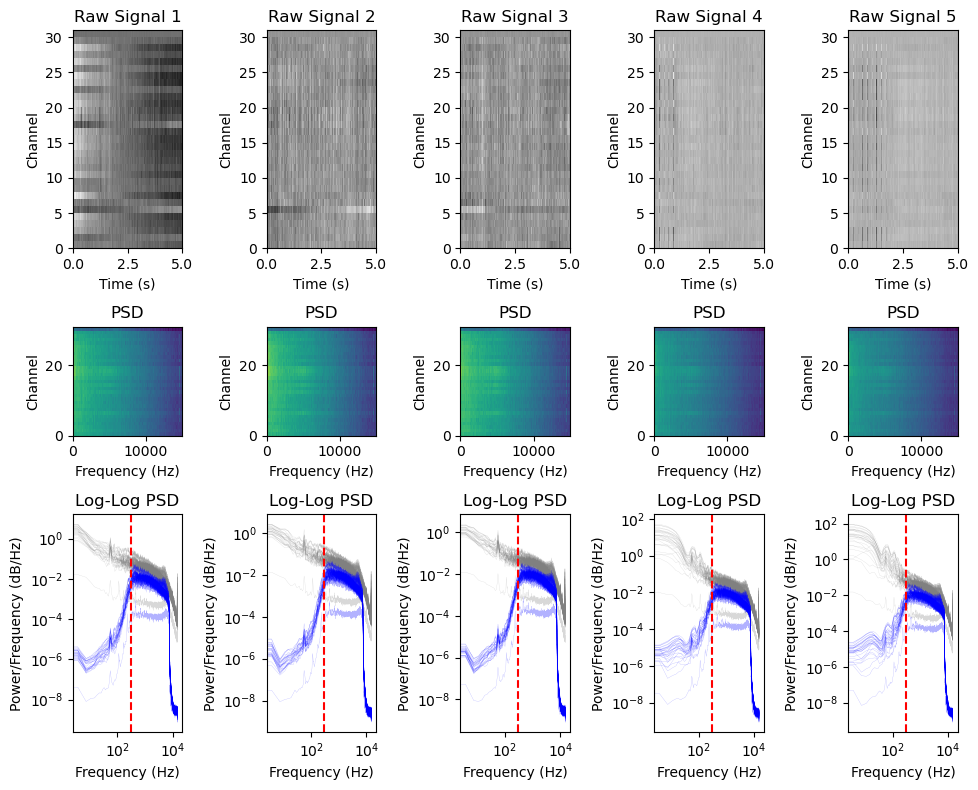

In [173]:
start_times = np.linspace(0, rec_length, num_bins+1)[:-1]+5  # start times for each bin
sampling_rate = 30000  # sampling rate in Hz

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, num_bins, figure=fig, height_ratios=[2, 1, 2])

for start_time_ind in range(num_bins):
    start_time_curr = start_times[start_time_ind]  # start time for the current bin
    end_time_curr = start_time_curr + chunk_size  # end time for the current bin

    with h5py.File(file_loc_raw, 'r') as f:
        dset = f['/samples']
        curr_signal_raw = dset[:,int(start_time_curr * sampling_rate):int(end_time_curr * sampling_rate)].T 
    # remove broken channels
    # broken_channel is 1-based, convert to 0-based
    broken_channel_idx = [i - 1 for i in broken_channel]

    # delete along axis=1 (columns)
    curr_signal_raw = np.delete(curr_signal_raw, broken_channel_idx, axis=1)
    curr_signal_raw = ADBitVolts * curr_signal_raw * 1e6  # convert to microvolts

    with h5py.File(file_loc_csc, 'r') as f:
        dset = f['/samples']
        curr_signal_csc = dset[:, int(start_time_curr * sampling_rate):int(end_time_curr * sampling_rate)].T
    curr_signal_csc = np.delete(curr_signal_csc, broken_channel_idx, axis=1)
    curr_signal_csc = ADBitVolts * curr_signal_csc * 1e6  # convert to microvolts
    
    # plot raw signal as gray scale
    ax1 = fig.add_subplot(gs[0, start_time_ind])
    ax1.imshow(curr_signal_raw.T - np.mean(curr_signal_raw.T, axis=1, keepdims=True), aspect='auto', cmap='gray', interpolation='none', extent=[0, chunk_size, 0, curr_signal_raw.shape[1]])
    ax1.set_title(f'Raw Signal {start_time_ind+1}')
    ax1.set_ylabel('Channel')
    ax1.set_xlabel('Time (s)')

    # power spectral density
    freqs, psd = welch(curr_signal_raw, fs=sampling_rate, nperseg=8096, axis=0)
    freqs_csc, psd_csc = welch(curr_signal_csc, fs=sampling_rate, nperseg=8096, axis=0)
    ax2 = fig.add_subplot(gs[1, start_time_ind])
    ax2.imshow(np.log10(psd.T), aspect='auto', cmap='viridis', interpolation='none', extent=[freqs[0], freqs[-1], 0, curr_signal_raw.shape[1]])
    ax2.set_title(f'PSD')
    ax2.set_ylabel('Channel')
    ax2.set_xlabel('Frequency (Hz)')

    # plot in log log scale
    ax3 = fig.add_subplot(gs[2, start_time_ind])
    ax3.loglog(freqs, psd, color='gray', alpha=0.3, linewidth=0.2)
    ax3.loglog(freqs_csc, psd_csc, color='blue', linewidth=0.2, alpha=0.3)
    ax3.set_title(f'Log-Log PSD')
    ax3.set_ylabel('Power/Frequency (dB/Hz)')
    ax3.set_xlabel('Frequency (Hz)')

    ax3.axvline(300, color='red', linestyle='--', label='300 Hz')
plt.tight_layout()